In [2]:
import pandas as pd
import numpy as np
import datetime
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import dask.dataframe as dd
from dask.multiprocessing import get
import numpy as np
import librosa
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.stats import kurtosis
import scipy.signal as signal
from scipy.integrate import simps


In [3]:
df = pd.read_csv('all_clubed.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'uuid', 'datetime', 'cough_detected', 'latitude',
       'longitude', 'age', 'gender', 'respiratory_condition',
       'fever_muscle_pain', 'status', 'quality_1', 'cough_type_1', 'dyspnea_1',
       'wheezing_1', 'stridor_1', 'choking_1', 'congestion_1', 'nothing_1',
       'diagnosis_1', 'severity_1', 'quality_2', 'cough_type_2', 'dyspnea_2',
       'wheezing_2', 'stridor_2', 'choking_2', 'congestion_2', 'nothing_2',
       'diagnosis_2', 'severity_2', 'quality_3', 'dyspnea_3', 'wheezing_3',
       'stridor_3', 'choking_3', 'congestion_3', 'nothing_3', 'cough_type_3',
       'diagnosis_3', 'severity_3', 'severity', 'cough_type', 'dyspnea',
       'wheezing', 'stridor', 'quality', 'choking', 'congestion', 'nothing',
       'diagnosis'],
      dtype='object')

In [5]:
cd_status_df= df.dropna(subset=[ 'cough_detected', 'status'], inplace=False)[['cough_detected', 'status']]

In [12]:
temp_df = cd_status_df.sample(n=1000, random_state=7)

In [7]:
cd_status_df['status'].value_counts(normalize =True)

status
healthy        0.756762
symptomatic    0.153969
COVID-19       0.089270
Name: proportion, dtype: float64

In [13]:
temp_df['status'].value_counts(normalize =True)

status
healthy        0.766
symptomatic    0.152
COVID-19       0.082
Name: proportion, dtype: float64

In [14]:
group1 = temp_df[temp_df['status']=='healthy']['cough_detected'].values
group2 = temp_df[temp_df['status']=='symptomatic']['cough_detected'].values
group3 = temp_df[temp_df['status']=='COVID-19']['cough_detected'].values

In [15]:
import scipy.stats as stats
f_statistic, p_value = stats.f_oneway(group1, group2, group3)
alpha = 0.05
print("F-statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. There are significant differences among the groups.")
else:
    print("Fail to reject the null hypothesis. There are no significant differences among the groups.")


F-statistic: 5.4355375903104015
P-value: 0.00448903605169318
Reject the null hypothesis. There are significant differences among the groups.


<Axes: >

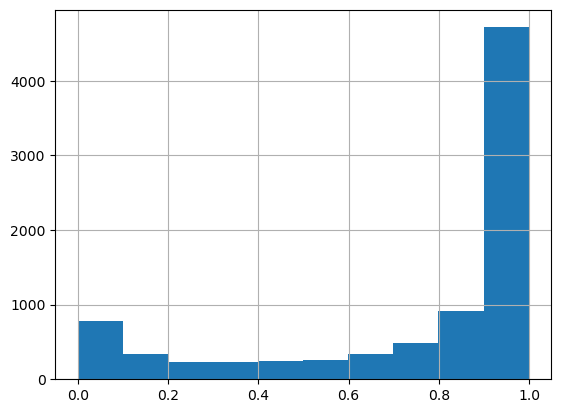

In [39]:
cd_status_df[cd_status_df['status']=='healthy']['cough_detected'].hist()

<Axes: >

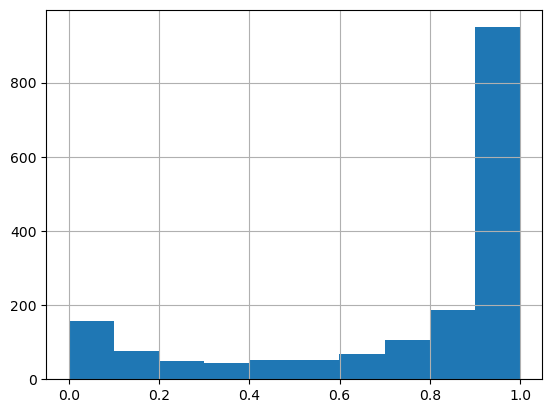

In [40]:
cd_status_df[cd_status_df['status']=='symptomatic']['cough_detected'].hist()

<Axes: >

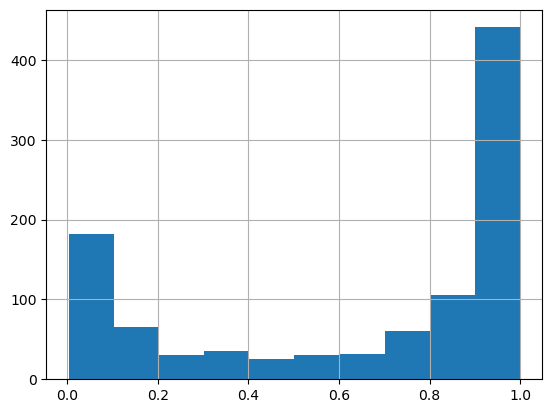

In [42]:
cd_status_df[cd_status_df['status']=='COVID-19']['cough_detected'].hist()

In [45]:
cd_status_df.groupby('status')['cough_detected'].mean()

status
COVID-19       0.646101
healthy        0.751854
symptomatic    0.749087
Name: cough_detected, dtype: float64

In [16]:
temp_df.groupby('status')['cough_detected'].mean()

status
COVID-19       0.623259
healthy        0.749575
symptomatic    0.731825
Name: cough_detected, dtype: float64

In [48]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

df = cd_status_df
model = sm.OLS.from_formula('cough_detected ~ status', data=df)
results = model.fit()
anova_table = sm.stats.anova_lm(results)
mc = MultiComparison(df['cough_detected'], df['status'])
tukey_result = mc.tukeyhsd()
print("ANOVA results:")
print(anova_table)
print("\nTukey's HSD results:")
print(tukey_result)


ANOVA results:
               df       sum_sq   mean_sq          F        PR(>F)
status        2.0    10.207364  5.103682  47.282369  3.555422e-21
Residual  11311.0  1220.914816  0.107940        NaN           NaN

Tukey's HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1     group2   meandiff p-adj lower  upper  reject
--------------------------------------------------------
COVID-19     healthy   0.1058   0.0 0.0801 0.1314   True
COVID-19 symptomatic    0.103   0.0 0.0725 0.1334   True
 healthy symptomatic  -0.0028 0.945 -0.023 0.0175  False
--------------------------------------------------------


group1,group2,meandiff,p-adj,lower,upper,reject
COVID-19,healthy,0.1058,0.0,0.0801,0.1314,True
COVID-19,symptomatic,0.103,0.0,0.0725,0.1334,True
healthy,symptomatic,-0.0028,0.945,-0.023,0.0175,False


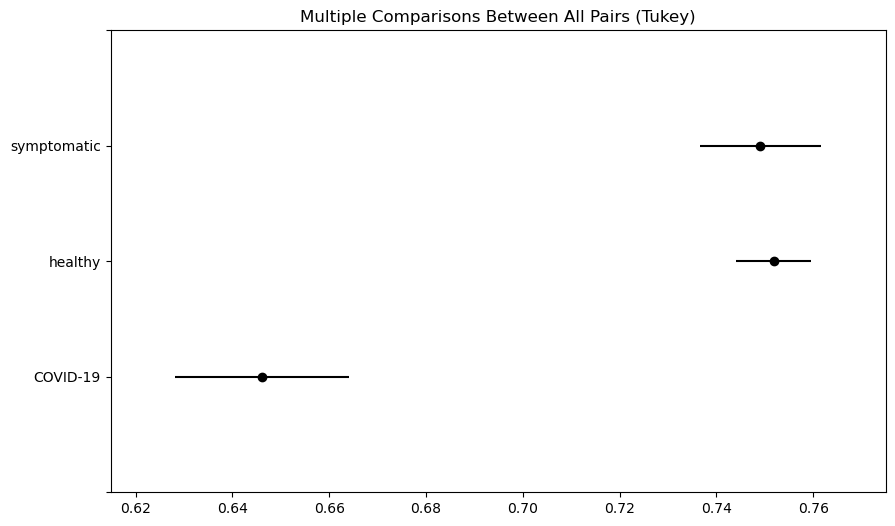

In [50]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=cd_status_df['cough_detected'],     # Data
                          groups=cd_status_df['status'],   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()    